In [2]:
pip install pandas numpy scikit-learn geopandas shapely fiona pyproj rtree xgboost


  Using cached geopandas-1.1.1-py3-none-any.whl.metadata (2.3 kB)
  Using cached rtree-1.4.1-py3-none-macosx_11_0_arm64.whl.metadata (2.1 kB)
  Using cached click_plugins-1.1.1.2-py2.py3-none-any.whl.metadata (6.5 kB)
  Using cached cligj-0.7.2-py3-none-any.whl.metadata (5.0 kB)
Using cached geopandas-1.1.1-py3-none-any.whl (338 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 48.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 32.9 MB/s eta 0:00:00
Using cached rtree-1.4.1-py3-none-macosx_11_0_arm64.whl (436 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 46.3 MB/s eta 0:00:00
Using cached click_plugins-1.1.1.2-py2.py3-none-any.whl (11 kB)
Using cached cligj-0.7.2-py3-none-any.whl (7.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 45.3 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9/9 [geopandas]/9 [geopandas]ins]


In [3]:
pip install dbfread

  Using cached dbfread-2.0.7-py2.py3-none-any.whl.metadata (3.3 kB)
Using cached dbfread-2.0.7-py2.py3-none-any.whl (20 kB)
Note: you may need to restart the kernel to use updated packages.


Loaded 227428 rows.
Matched: 181871 rows to boroughs.
Original #categories: 251
Grouped into: 31 categories (incl. 'Other').
Context rows: 835

========== MODEL EVALUATION ==========
Train MSE: 1.8607569905943023e-06
Test MSE: 0.0015568482960376347
Train RMSE: 0.0013640956676840164
Test RMSE: 0.03945691696062472
MAE: 0.017317713880758305
Overall R^2: 0.6717069112003783


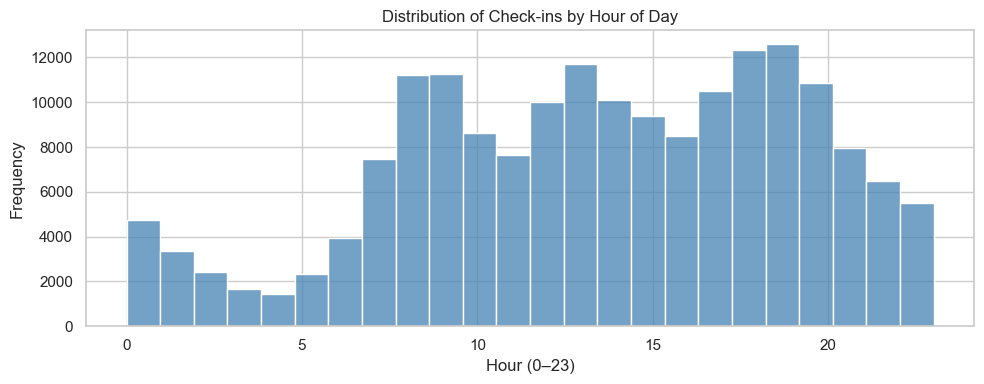

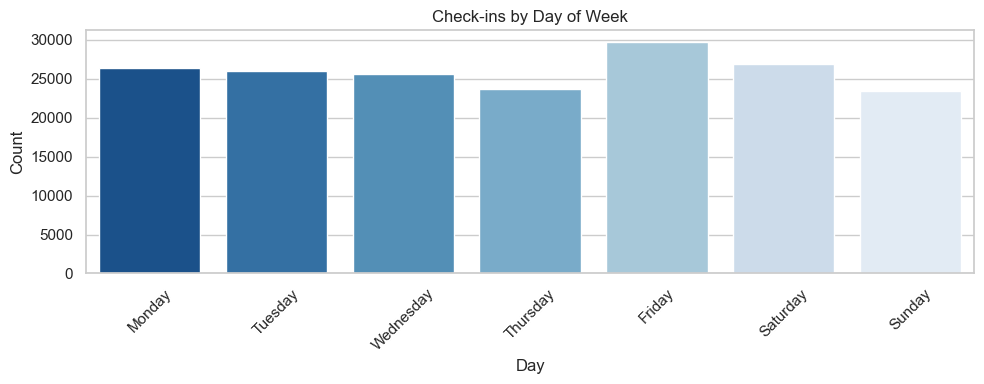

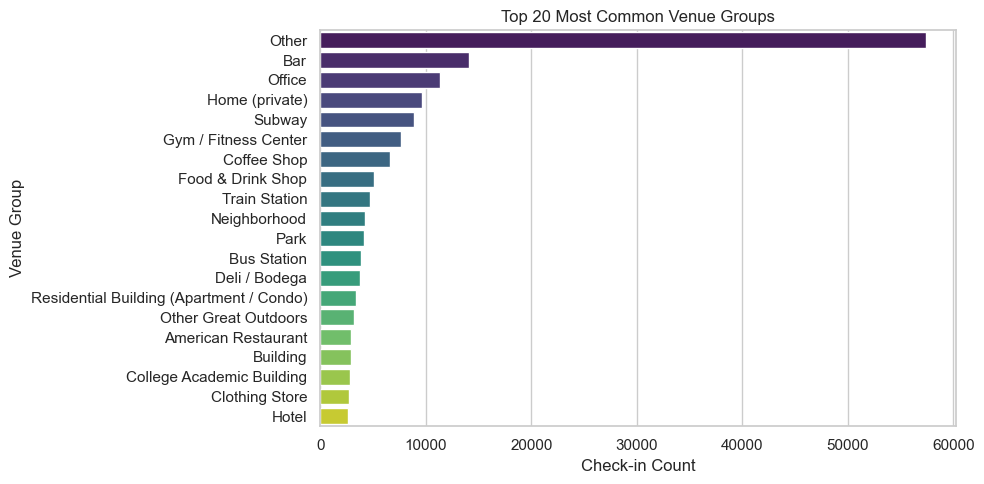

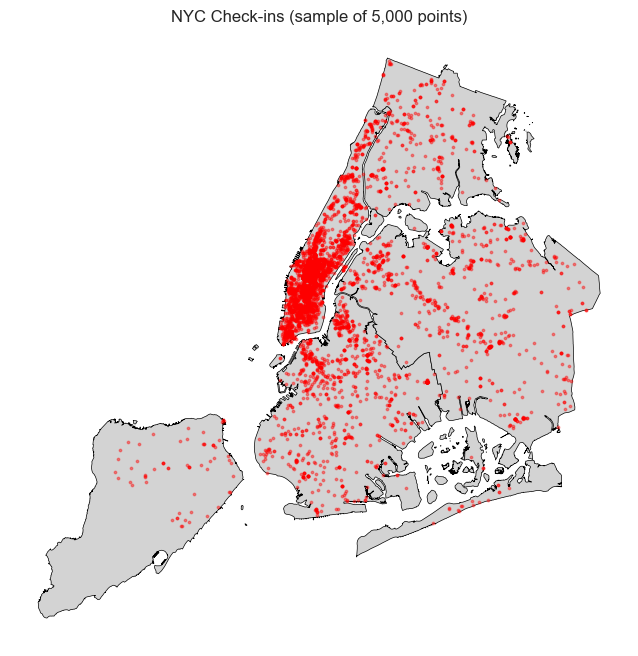

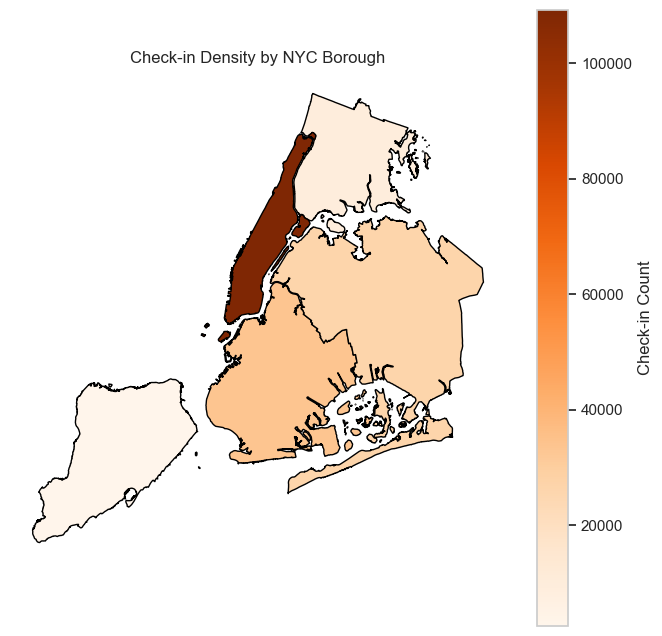

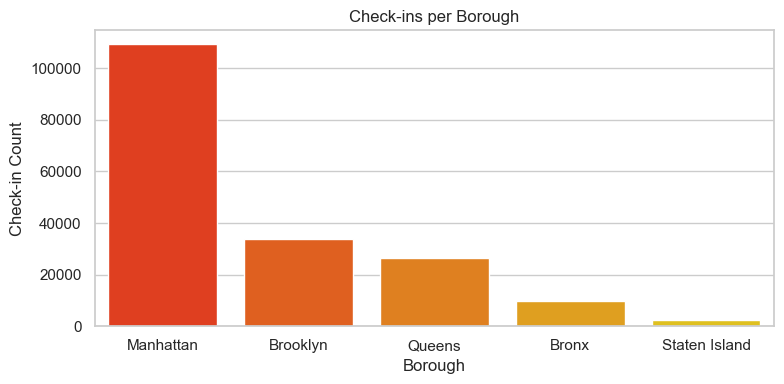


========== METRICS SUMMARY ==========
TRAIN MSE: 1.8607569905943023e-06
TEST MSE: 0.0015568482960376347
TRAIN RMSE: 0.0013640956676840164
TEST RMSE: 0.03945691696062472
MAE: 0.017317713880758305
R² (overall): 0.6717069112003783


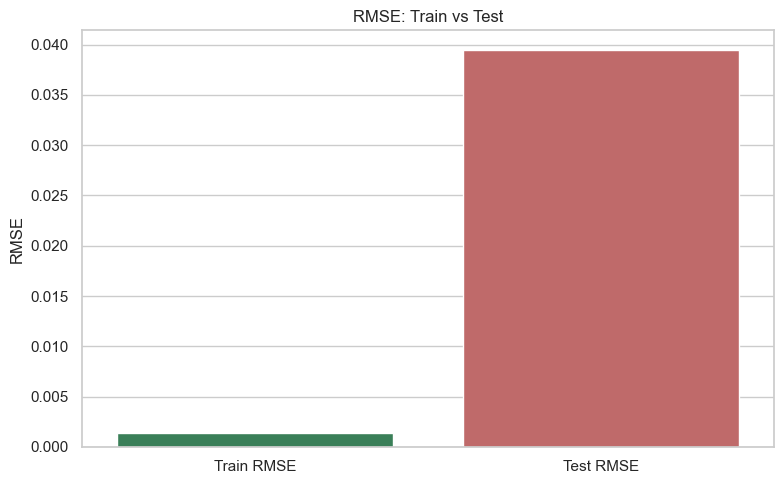

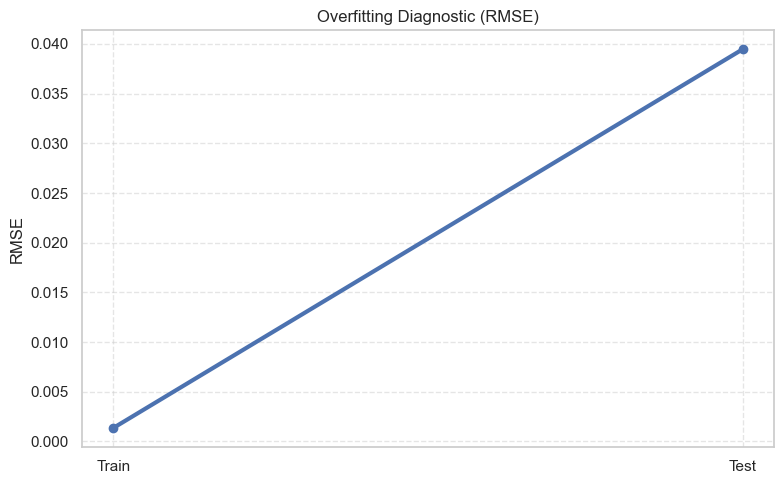

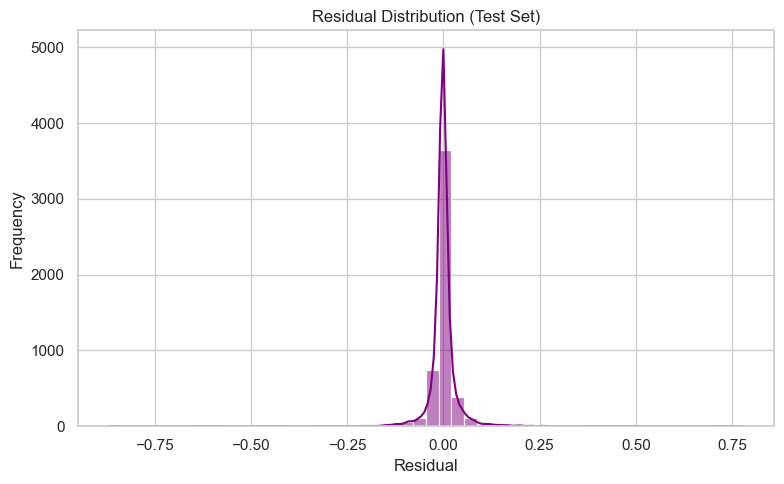


 Prediction for Manhattan on a Friday at 9 PM:
Other                                       0.218744
Bar                                         0.157940
American Restaurant                         0.056272
Movie Theater                               0.042934
Italian Restaurant                          0.037094
Subway                                      0.036433
Mexican Restaurant                          0.033306
Pizza Place                                 0.029748
Home (private)                              0.029045
Food & Drink Shop                           0.027162
Train Station                               0.025310
Residential Building (Apartment / Condo)    0.024926
Office                                      0.023955
Gym / Fitness Center                        0.022000
Coffee Shop                                 0.021868
dtype: float32


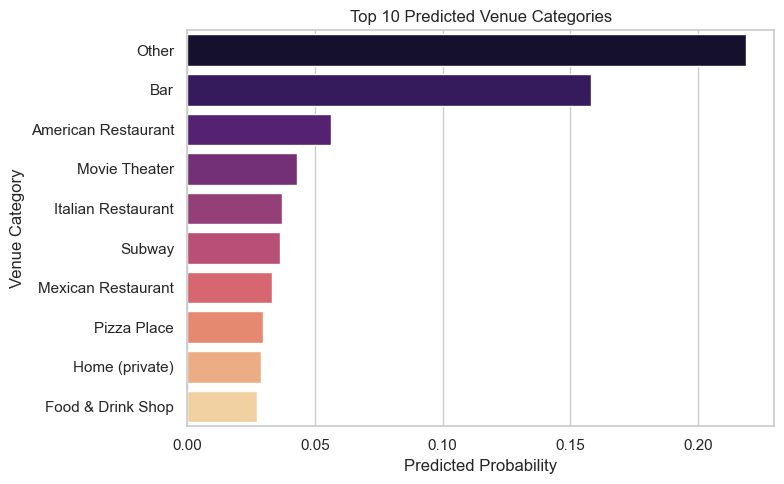

<function print(*args, sep=' ', end='\n', file=None, flush=False)>

In [6]:
import warnings
warnings.filterwarnings("ignore")

# ============================================================
# Imports
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score
)

from xgboost import XGBRegressor

sns.set(style="whitegrid")


# 1. LOAD RAW DATA

def load_raw_data():
    fp = "/Users/chardog234/Documents/GitHub/Final_project_4003/dataset_TSMC2014_NYC.csv"
    df = pd.read_csv(fp, encoding="ISO-8859-1")
    print(f"Loaded {len(df)} rows.")
    return df


# 2. NORMALIZE TIME


def normalize_times(df):
    df = df.copy()

    df["UTC_Time"] = pd.to_datetime(
        df["utcTimestamp"],
        utc=True,
        format="%a %b %d %H:%M:%S +0000 %Y",
        errors="coerce"
    )

    df = df.dropna(subset=["UTC_Time"])

    # NOTE: timezoneOffset is in minutes; dataset appears to be local = UTC + offset
    df["Local_Time"] = df["UTC_Time"] + pd.to_timedelta(df["timezoneOffset"], unit="m") #basically adds the timezone offset to the UTC time 
    #to get local time or eastern timezone
    df["Day_of_Week"] = df["Local_Time"].dt.day_name()
    df["Hour"] = df["Local_Time"].dt.hour

    return df


# 3. ATTACH BOROUGH ZONES


def attach_borough_zones(df):
    shp = "/Users/chardog234/Documents/GitHub/Final_project_4003/geo_export_3c9604c8-be29-4e21-ae16-9c7d64ebce63.shp" #load shapefile
    boroughs = gpd.read_file(shp).to_crs(epsg=4326) #convert coordinate system to EPSG:4326 which is used by foursquare
#here we convert the checkins into a geodataframe so we can perform spatial analysis like joins
    gdf = gpd.GeoDataFrame( 
        df.copy(), #make a copy to not overwrite original 
        geometry=[Point(xy) for xy in zip(df["longitude"], df["latitude"])], #essentially creates the geometry column of the geodataframe 
        #using the longitude and latitude columns from the original dataframe 
        crs="EPSG:4326" #coordinate systems 
    ) 
#this is our spatial join where we match the checkin points to the borough polygons
    joined = gpd.sjoin(
        gdf,  #first takes in our geodatagrame of checkins
        boroughs[["boroname", "geometry"]], #joins each points to each borough polygon based on location
        how="left", #basically all the points that don't match to a borough will be NaN, we ended up with a lot that didn't match, 
        #pretty sure foursqaure included points outside of NYC
        predicate="within" #this is the type of spatial join we are doing, within means we are looking for points within polygons obviously
    )

    joined = joined.rename(columns={"boroname": "Borough_ID"}) #rename
    joined = joined.dropna(subset=["Borough_ID"]) #Removes all NAN rows, takes away all points that werent in the borough boundary
    joined = joined.drop(columns=["index_right"]) #drop unnecessary column from spatial join

    print("Matched:", len(joined), "rows to boroughs.") #Prints to show how many points were matched to boroughs
    return joined, boroughs #Return the joined dataframe and the boroughs polygon layer


# 4. CATEGORY SIMPLIFICATION  (#1 + #5)


def simplify_categories(df, top_xamount=30, min_count=50):
    #make copy to not overwrite original
    df = df.copy() 
    #literally just counting how many times each category appears
    venueCount = df["venueCategory"].value_counts() 
    # here we create a variable named frequent that first removes all categories that appear less than 50 times(min_count)
    # then we take the most frequent of of those, set at 30 or top_xamount
    frequent = venueCount[venueCount >= min_count].head(top_xamount).index 
    #Add a new column to the dataframe where if the category is in the frequent list we keep it, otherwise we set it as Other
    df["venueCategory_grouped"] = df["venueCategory"].where(
        df["venueCategory"].isin(frequent),
        other="Other"
    )
    #Just printing the number of original categories vs the new grouped categories
    print(f"Original #categories: {df['venueCategory'].nunique()}")
    print(f"Grouped into: {df['venueCategory_grouped'].nunique()} categories (incl. 'Other').")

    return df


# ============================================================
# 5. BUILD SOFT LABEL CONTEXTS  (#9 smoothing)
# ============================================================
def build_soft_contexts(df, category_col="venueCategory_grouped", alpha=0.3):
   #build out a context
    group_cols = ["Borough_ID", "Day_of_Week", "Hour"]

    counts = (
        df.groupby(group_cols + [category_col])
          .size()
          .reset_index(name="freq")
    )

    # Laplace smoothing
    counts["freq_smoothed"] = counts["freq"] + alpha
    counts["prob"] = counts["freq_smoothed"] / counts.groupby(group_cols)["freq_smoothed"].transform("sum")

    pivot = counts.pivot_table(
        index=group_cols,
        columns=category_col,
        values="prob",
        fill_value=0.0
    ).reset_index()

    print("Context rows:", len(pivot))
    return pivot


# ============================================================
# 6. MODEL (OneHot + tuned XGB + stratified split)
# ============================================================
class MovementModel:
    def __init__(self):
        self.model = None
        self.ohe = None
        self.categories = None

    def fit(self, df_ctx):
        df = df_ctx.copy()
        #grabs contexts
        keys = ["Borough_ID", "Day_of_Week", "Hour"]
        self.categories = [c for c in df.columns if c not in keys]
        #X is input contexts, Y is target venue categories
        X_raw = df[keys]
        Y = df[self.categories]

        # One-hot encode the categorical inputs
        self.ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
        #produces numeric training matrix
        X_all = self.ohe.fit_transform(X_raw)

        # stratify by borough so every borough is in both train and test
        strat_labels = X_raw["Borough_ID"]
        #makes the variables available outside of the fit function
        global X_train, X_test, Y_train, Y_test
        global preds_train, preds_test, r2_per_category, overall_r2

        X_train, X_test, Y_train, Y_test = train_test_split(
            X_all,
            Y,
            test_size=0.2, # 80% training 20% testing
            random_state=42,
            stratify=strat_labels
        )

        # Tuned XGBoost
        base = XGBRegressor(
            objective="reg:squarederror", #regression using squared error loss
            n_estimators=600, # number of trees
            learning_rate=0.05, # How strongly each tree corrects the mistakes of those before it
            max_depth=10, # limit of how deep it grows, pretty high because data is complex
            subsample=0.9, #trains on 90% of rows
            colsample_bytree=0.9, #uses 90% of features
            reg_lambda=1.0, #L2 regularization term on weights
            n_jobs=-1 #use all CPU cores
        )
        #creates one model per category
        self.model = MultiOutputRegressor(base)
        #trains the model
        self.model.fit(X_train, Y_train)
        #Predicts venue catefories for both train 
        preds_train = self.model.predict(X_train)
        #and test sets
        preds_test = self.model.predict(X_test)
        # flattens into one long 1D array for MSE calculation
        train_mse = mean_squared_error(Y_train.values.flatten(), preds_train.flatten())
        test_mse = mean_squared_error(Y_test.values.flatten(), preds_test.flatten())
        #rmse is just sqrt of mse
        train_rmse = train_mse ** 0.5
        test_rmse = test_mse ** 0.5
        #mean absolute error 
        mae = mean_absolute_error(Y_test.values.flatten(), preds_test.flatten())
        # overall R^2
        overall_r2 = r2_score(Y_test.values.flatten(), preds_test.flatten())

        # per-category R²
        r2_scores = {}
        for i, cat in enumerate(self.categories):
            r2_scores[cat] = r2_score(Y_test.iloc[:, i], preds_test[:, i])
        r2_per_category = pd.Series(r2_scores)

        print("\n========== MODEL EVALUATION ==========")
        print("Train MSE:", train_mse)
        print("Test MSE:", test_mse)
        print("Train RMSE:", train_rmse)
        print("Test RMSE:", test_rmse)
        print("MAE:", mae)
        print("Overall R^2:", overall_r2)

    def predict_distribution(self, borough, day, hour, temperature=1.5):
        """
        Predict smoothed probability distribution over venue categories
        for a given (borough, day, hour).
        Uses OneHotEncoder internally.
        """
        X_raw = pd.DataFrame([{
            "Borough_ID": borough,
            "Day_of_Week": day,
            "Hour": hour
        }])

        X_enc = self.ohe.transform(X_raw)
        raw = self.model.predict(X_enc)[0]

        # non-negative and temperature smoothing
        raw = np.maximum(raw, 0)
        raw = raw ** (1.0 / temperature)

        total = raw.sum()
        if total == 0:
            probs = np.ones_like(raw) / len(raw)
        else:
            probs = raw / total

        return pd.Series(probs, index=self.categories).sort_values(ascending=False)


# ============================================================
# 7. RUN PIPELINE
# ============================================================
df = load_raw_data()
df = normalize_times(df)
df, boroughs = attach_borough_zones(df)
df = simplify_categories(df, top_xamount=30, min_count=50)
df_ctx = build_soft_contexts(df, category_col="venueCategory_grouped", alpha=0.3)

model = MovementModel()
model.fit(df_ctx)

# ============================================================
# 8. BASIC DISTRIBUTION VISUALIZATIONS (no heatmap)
# ============================================================
# Convert to GeoDataFrame for maps
gdf_points = gpd.GeoDataFrame(
    df.copy(),
    geometry=[Point(xy) for xy in zip(df["longitude"], df["latitude"])],
    crs="EPSG:4326"
)

# 1. Histogram: Check-ins per hour
plt.figure(figsize=(10, 4))
sns.histplot(df["Hour"], bins=24, kde=False, color="steelblue")
plt.title("Distribution of Check-ins by Hour of Day")
plt.xlabel("Hour (0–23)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# 2. Histogram: Check-ins per day
plt.figure(figsize=(10, 4))
order_days = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
sns.countplot(data=df, x="Day_of_Week", order=order_days, palette="Blues_r")
plt.title("Check-ins by Day of Week")
plt.xlabel("Day")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. Bar: Top 20 venue groups
plt.figure(figsize=(10, 5))
top_20 = df["venueCategory_grouped"].value_counts().head(20)
sns.barplot(x=top_20.values, y=top_20.index, palette="viridis")
plt.title("Top 20 Most Common Venue Groups")
plt.xlabel("Check-in Count")
plt.ylabel("Venue Group")
plt.tight_layout()
plt.show()

# 4. Simple map: points over boroughs
fig, ax = plt.subplots(figsize=(8, 8))
boroughs.plot(ax=ax, color="lightgray", edgecolor="black", linewidth=0.5)
gdf_points.sample(5000, random_state=42).plot(
    ax=ax, markersize=3, alpha=0.4, color="red"
)
plt.title("NYC Check-ins (sample of 5,000 points)")
plt.axis("off")
plt.show()

# 5. Choropleth: check-ins per borough
borough_counts = df.groupby("Borough_ID").size().reset_index(name="count")
boroughs_plot = boroughs.merge(borough_counts, left_on="boroname", right_on="Borough_ID", how="left")
boroughs_plot["count"] = boroughs_plot["count"].fillna(0)

fig, ax = plt.subplots(figsize=(8, 8))
boroughs_plot.plot(
    ax=ax,
    column="count",
    cmap="Oranges",
    legend=True,
    legend_kwds={"label": "Check-in Count"},
    edgecolor="black"
)
plt.title("Check-in Density by NYC Borough")
plt.axis("off")
plt.show()

# 6. Bar: check-ins per borough
plt.figure(figsize=(8, 4))
sns.barplot(
    data=borough_counts.sort_values("count", ascending=False),
    x="Borough_ID", y="count", palette="autumn"
)
plt.title("Check-ins per Borough")
plt.xlabel("Borough")
plt.ylabel("Check-in Count")
plt.tight_layout()
plt.show()


# ============================================================
# 9. EVALUATION VISUALIZATIONS
# ============================================================
# recompute metrics from global vars
train_mse = mean_squared_error(Y_train.values.flatten(), preds_train.flatten())
test_mse = mean_squared_error(Y_test.values.flatten(), preds_test.flatten())
train_rmse = train_mse ** 0.5
test_rmse = test_mse ** 0.5

print("\n========== METRICS SUMMARY ==========")
print("TRAIN MSE:", train_mse)
print("TEST MSE:", test_mse)
print("TRAIN RMSE:", train_rmse)
print("TEST RMSE:", test_rmse)
print("MAE:", mean_absolute_error(Y_test.values.flatten(), preds_test.flatten()))
print("R² (overall):", r2_score(Y_test.values.flatten(), preds_test.flatten()))

# 1. RMSE bar chart
plt.figure(figsize=(8,5))
sns.barplot(
    x=["Train RMSE", "Test RMSE"],
    y=[train_rmse, test_rmse],
    palette=["seagreen", "indianred"]
)
plt.title("RMSE: Train vs Test")
plt.ylabel("RMSE")
plt.tight_layout()
plt.show()

# 2. Overfitting diagnostic line
plt.figure(figsize=(8,5))
plt.plot(["Train","Test"], [train_rmse, test_rmse], marker="o", linewidth=3)
plt.title("Overfitting Diagnostic (RMSE)")
plt.ylabel("RMSE")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# 3. Residual distribution (test)
residuals = (Y_test.values.flatten() - preds_test.flatten())
plt.figure(figsize=(8,5))
sns.histplot(residuals, bins=50, kde=True, color="purple")
plt.title("Residual Distribution (Test Set)")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# ============================================================
# 10. PREDICTION: MANHATTAN, FRIDAY @ 9 PM
# ============================================================

TARGET_BOROUGH = "Manhattan"
TARGET_DAY = "Friday"
TARGET_HOUR = 21   # 9 PM

print("\n Prediction for Manhattan on a Friday at 9 PM:")

prediction = model.predict_distribution(
    borough=TARGET_BOROUGH,
    day=TARGET_DAY,
    hour=TARGET_HOUR,
    temperature=1.5
)

print(prediction.head(15))  # show top 15 categories

# Optional visualization
plt.figure(figsize=(8,5))
sns.barplot(x=prediction.head(10).values, y=prediction.head(10).index, palette="magma")
plt.title("Top 10 Predicted Venue Categories")
plt.xlabel("Predicted Probability")
plt.ylabel("Venue Category")
plt.tight_layout()
plt.show()

print

Loaded 227428 rows.
Original categories: 251
Reduced to 31 (incl. 'Other')
Matched 181870 rows to COMMUNITY DISTRICTS
District context rows: 10162

===== COMMUNITY DISTRICT MODEL EVALUATION =====
Train RMSE: 0.027916595081607348
Test RMSE: 0.09139047063377204
MAE: 0.03128776718062514
R²: 0.32046435847512444


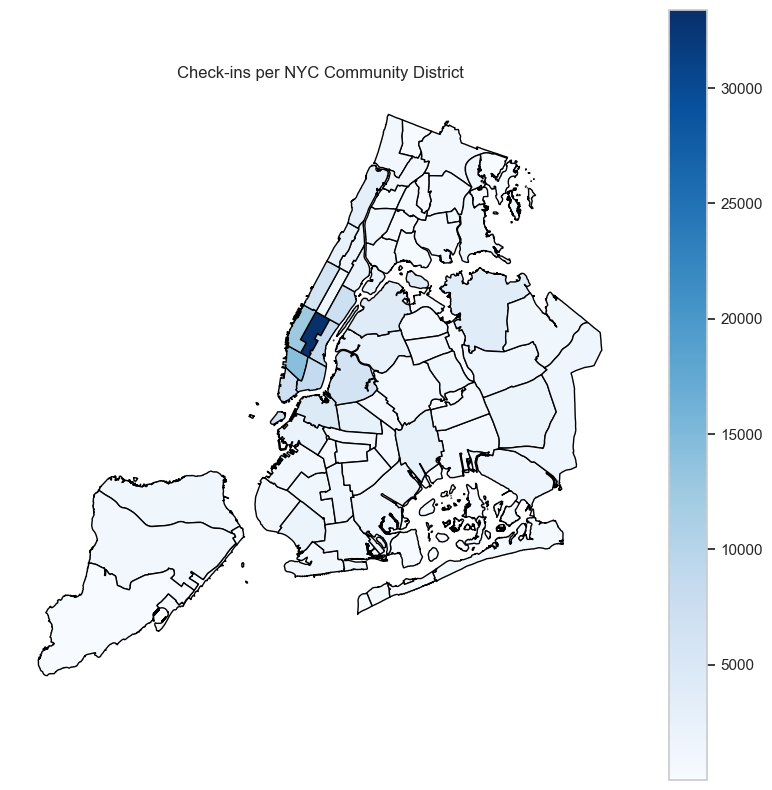

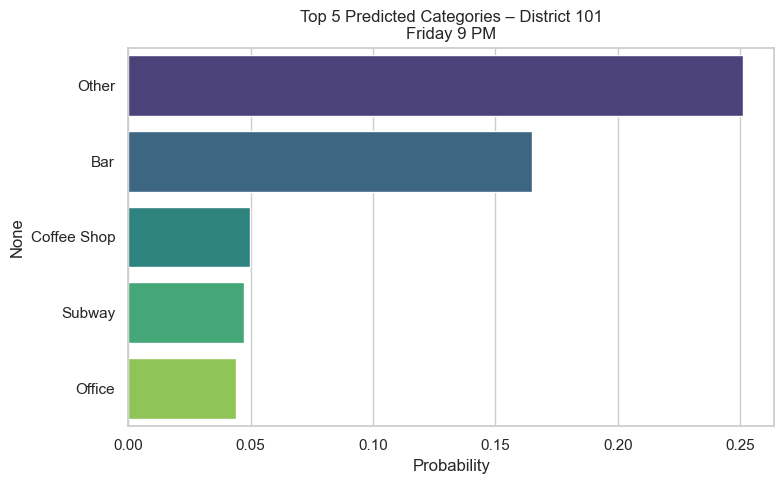

In [ ]:
# ============================================================
# ADDING NYC COMMUNITY DISTRICTS INTO THE PIPELINE (SEPARATE)
# ============================================================

import warnings
warnings.filterwarnings("ignore")

# Libraries
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from shapely.geometry import Point
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

sns.set(style="whitegrid")


# ============================================================
# 0. BASE FUNCTIONS (from your main pipeline)
# ============================================================

def load_raw_data():
    fp = "/Users/chardog234/Documents/GitHub/Final_project_4003/dataset_TSMC2014_NYC.csv"
    df = pd.read_csv(fp, encoding="ISO-8859-1")
    print(f"Loaded {len(df)} rows.")
    return df

def normalize_times(df):
    df = df.copy()
    df["UTC_Time"] = pd.to_datetime(
        df["utcTimestamp"], utc=True,
        format="%a %b %d %H:%M:%S +0000 %Y",
        errors="coerce"
    )
    df = df.dropna(subset=["UTC_Time"])
    df["Local_Time"] = df["UTC_Time"] + pd.to_timedelta(df["timezoneOffset"], unit="m")
    df["Day_of_Week"] = df["Local_Time"].dt.day_name()
    df["Hour"] = df["Local_Time"].dt.hour
    return df

def simplify_categories(df, top_k=30, min_count=50):
    df = df.copy()
    vc = df["venueCategory"].value_counts()
    frequent = vc[vc >= min_count].head(top_k).index
    df["venueCategory_grouped"] = df["venueCategory"].where(
        df["venueCategory"].isin(frequent),
        other="Other"
    )
    print(f"Original categories: {df['venueCategory'].nunique()}")
    print(f"Reduced to {df['venueCategory_grouped'].nunique()} (incl. 'Other')")
    return df


# ============================================================
# 1. LOAD COMMUNITY DISTRICTS SHAPEFILE
# ============================================================
def attach_district_zones(df):
    path = "/Users/chardog234/Downloads/nycd_25d/nycd.shp"
    districts = gpd.read_file(path).to_crs(epsg=4326)
    districts = districts.rename(columns={"BoroCD": "District_ID"})

    gdf = gpd.GeoDataFrame(
        df.copy(),
        geometry=[Point(xy) for xy in zip(df["longitude"], df["latitude"])],
        crs="EPSG:4326"
    )

    joined = gpd.sjoin(
        gdf,
        districts[["District_ID", "geometry"]],
        how="left",
        predicate="within"
    )

    joined = joined.dropna(subset=["District_ID"])
    joined = joined.drop(columns=["index_right"])

    print("Matched", len(joined), "rows to COMMUNITY DISTRICTS")
    return joined, districts


# ============================================================
# 2. BUILD DISTRICT CONTEXT TABLE
# ============================================================
def build_district_contexts(df, alpha=0.3):
    group_cols = ["District_ID", "Day_of_Week", "Hour"]

    counts = (
        df.groupby(group_cols + ["venueCategory_grouped"])
          .size()
          .reset_index(name="freq")
    )

    # Laplace smoothing
    counts["freq_smooth"] = counts["freq"] + alpha
    counts["prob"] = counts["freq_smooth"] / counts.groupby(group_cols)["freq_smooth"].transform("sum")

    pivot = counts.pivot_table(
        index=group_cols,
        columns="venueCategory_grouped",
        values="prob",
        fill_value=0.0
    ).reset_index()

    print("District context rows:", len(pivot))
    return pivot


# ============================================================
# 3. DISTRICT MODEL
# ============================================================
class DistrictModel:
    def __init__(self):
        self.model = None
        self.ohe = None
        self.categories = None

    def fit(self, df_ctx):
        df = df_ctx.copy()

        keys = ["District_ID", "Day_of_Week", "Hour"]
        self.categories = [c for c in df.columns if c not in keys]

        X_raw = df[keys]
        Y = df[self.categories]

        # One-hot encode features
        self.ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
        X_all = self.ohe.fit_transform(X_raw)

        # Stratified split by district
        global DX_train, DX_test, DY_train, DY_test
        global Dpred_train, Dpred_test, D_r2_per_cat

        DX_train, DX_test, DY_train, DY_test = train_test_split(
            X_all, Y,
            test_size=0.2,
            random_state=42,
            stratify=X_raw["District_ID"]
        )

        base = XGBRegressor(
            objective="reg:squarederror",
            n_estimators=700,
            learning_rate=0.05,
            max_depth=10,
            subsample=0.9,
            colsample_bytree=0.9
        )

        self.model = MultiOutputRegressor(base)
        self.model.fit(DX_train, DY_train)

        Dpred_train = self.model.predict(DX_train)
        Dpred_test = self.model.predict(DX_test)

        print("\n===== COMMUNITY DISTRICT MODEL EVALUATION =====")
        print("Train RMSE:", mean_squared_error(DY_train.values.flatten(), Dpred_train.flatten())**0.5)
        print("Test RMSE:", mean_squared_error(DY_test.values.flatten(), Dpred_test.flatten())**0.5)
        print("MAE:", mean_absolute_error(DY_test.values.flatten(), Dpred_test.flatten()))
        print("R²:", r2_score(DY_test.values.flatten(), Dpred_test.flatten()))

        # Per-category R²
        scores = {}
        for i, c in enumerate(self.categories):
            scores[c] = r2_score(DY_test.iloc[:, i], Dpred_test[:, i])
        D_r2_per_cat = pd.Series(scores)

    def predict_distribution(self, district, day, hour, temperature=1.3):
        X_raw = pd.DataFrame([{
            "District_ID": district,
            "Day_of_Week": day,
            "Hour": hour
        }])

        X_enc = self.ohe.transform(X_raw)

        raw = np.maximum(self.model.predict(X_enc)[0], 0)
        raw = raw ** (1/temperature)
        raw /= raw.sum()

        return pd.Series(raw, index=self.categories).sort_values(ascending=False)


# ============================================================
# 4. RUN THE DISTRICT PIPELINE (FIXED)
# ============================================================

df = load_raw_data()
df = normalize_times(df)
df = simplify_categories(df, top_k=30, min_count=50)

# Attach districts
df_districts, district_shapes = attach_district_zones(df)

# Build contexts
df_dist_ctx = build_district_contexts(df_districts)

# Train model
district_model = DistrictModel()
district_model.fit(df_dist_ctx)


# ============================================================
# 5. VISUALIZATIONS
# ============================================================

# ---- District Choropleth ----
district_counts = df_districts.groupby("District_ID").size().reset_index(name="count")
district_plot = district_shapes.merge(district_counts, on="District_ID", how="left")
district_plot["count"] = district_plot["count"].fillna(0)

fig, ax = plt.subplots(figsize=(10, 10))
district_plot.plot(
    ax=ax,
    column="count",
    cmap="Blues",
    legend=True,
    edgecolor="black"
)
plt.title("Check-ins per NYC Community District")
plt.axis("off")
plt.show()


# ---- Top 5 for Friday 9 PM ----
TARGET_DAY = "Friday"
TARGET_HOUR = 21

example_district = 101  # Manhattan CD1 example
pred = district_model.predict_distribution(example_district, TARGET_DAY, TARGET_HOUR)

plt.figure(figsize=(8,5))
sns.barplot(x=pred.head(5).values, y=pred.head(5).index, palette="viridis")
plt.title(f"Top 5 Predicted Categories – District {example_district}\nFriday 9 PM")
plt.xlabel("Probability")
plt.tight_layout()
plt.show()
